In [1]:
import numpy as np
import h5py as h5
from matplotlib import pyplot as plt
import tensorflow as tf
import os

In [2]:
from omnifold import DataLoader, MultiFold, MLP, SetStyle, HistRoutine

In [3]:
data_path = '/global/cfs/cdirs/ntrain1/unfolding'

In [4]:
nevts = 100_000
gen_data = h5.File(os.path.join(data_path,'train_herwig.h5'))['gen_subs'][:nevts]
reco_data = h5.File(os.path.join(data_path,'train_herwig.h5'))['reco_subs'][:nevts]
gen_mc = h5.File(os.path.join(data_path,'train_pythia.h5'))['gen_subs'][:nevts]
reco_mc = h5.File(os.path.join(data_path,'train_pythia.h5'))['reco_subs'][:nevts]

data = DataLoader(reco = reco_data,normalize=True)
mc = DataLoader(reco = reco_mc,gen = gen_mc,normalize=True)

INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Normalizing sum of weights to 1000000 ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Normalizing sum of weights to 1000000 ...


## Let's take a quick look at the data

In [5]:
SetStyle()

In [6]:
var_names = ["Jet Mass [GeV]","Jet Width", "$n_{constituents}$",r"$ln\rho$","$z_g$",r"$\tau_{21}$"]
nbins = 50
binning = [
        np.linspace(0,75,nbins),
        np.linspace(0,0.6,nbins),
        np.linspace(0,80,80),
        np.linspace(-14,-2,nbins),
        np.linspace(0.0,0.5,nbins),
        np.linspace(0.0,1.2,nbins),
    ]

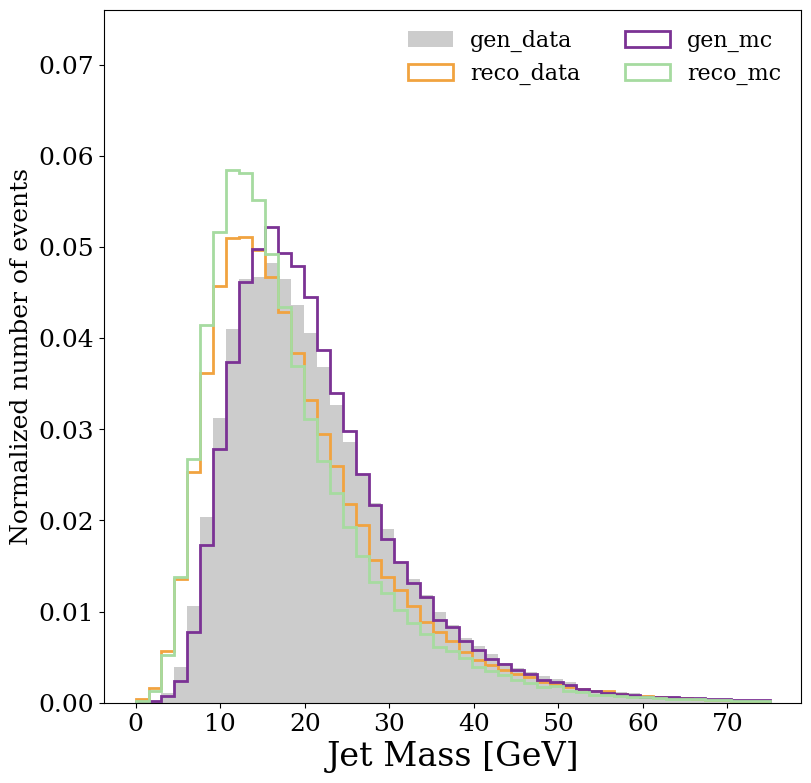

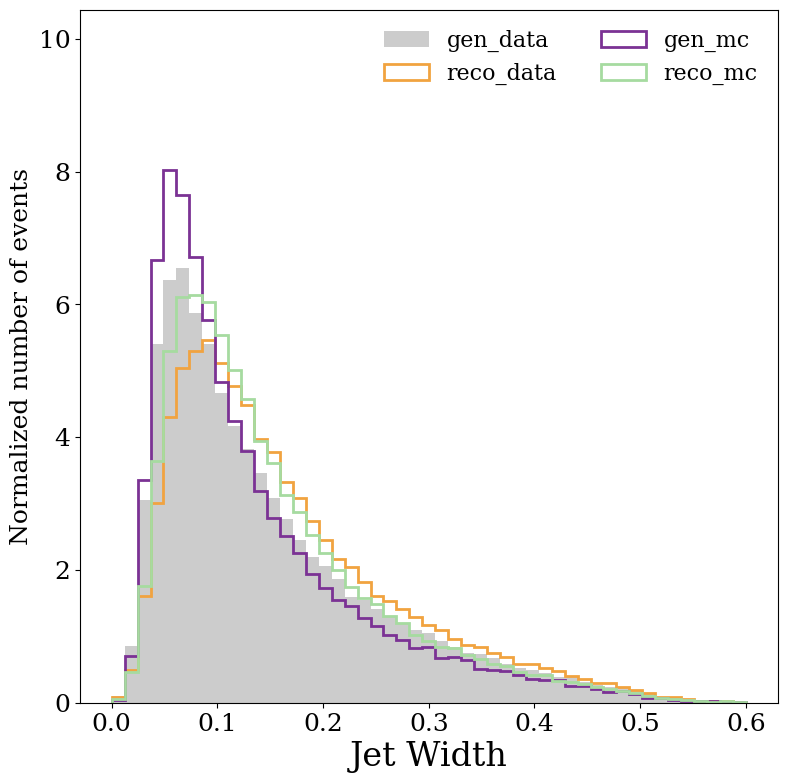

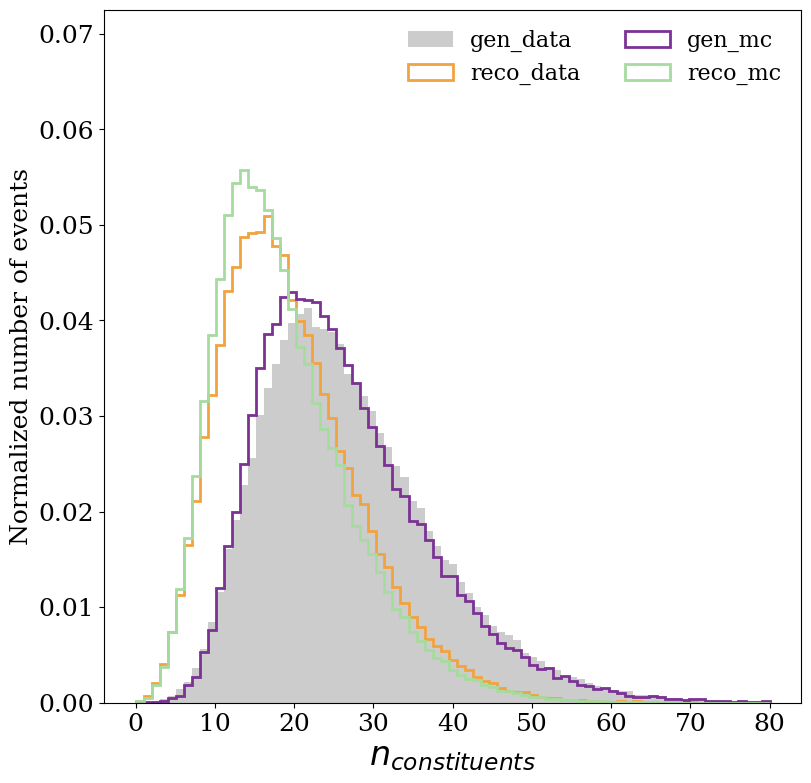

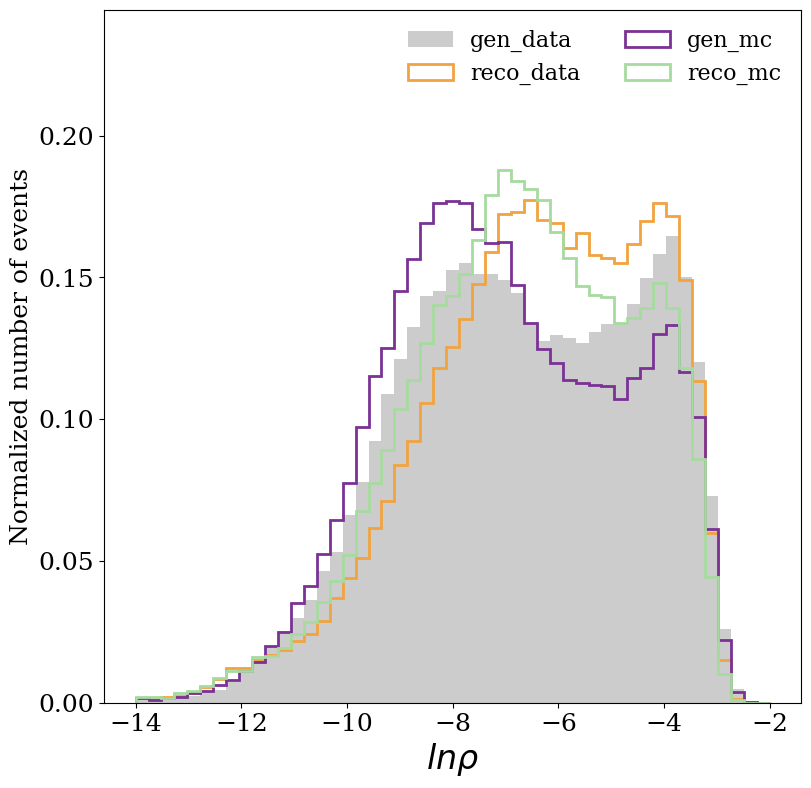

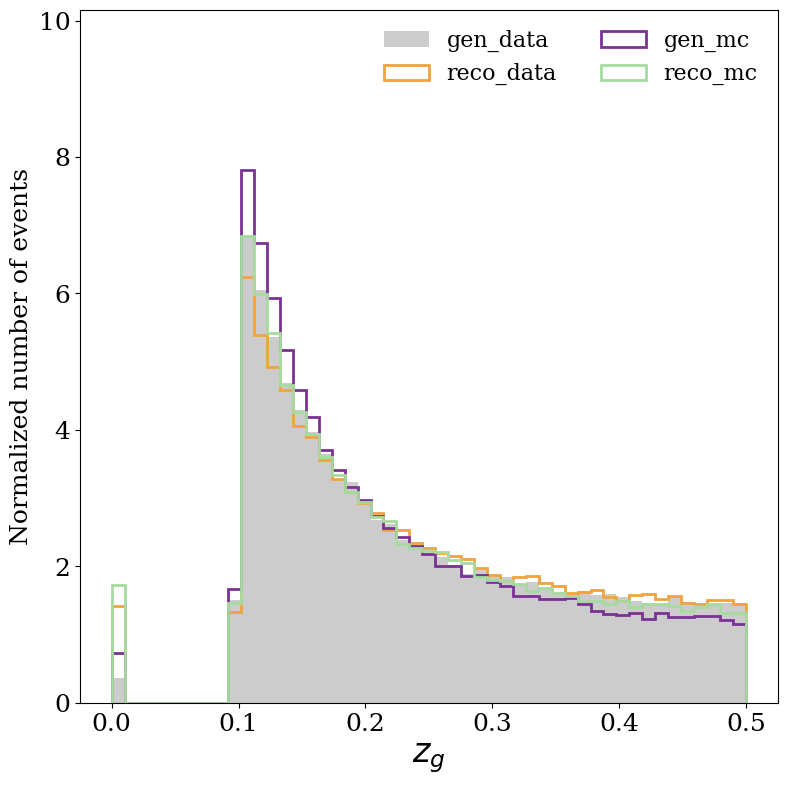

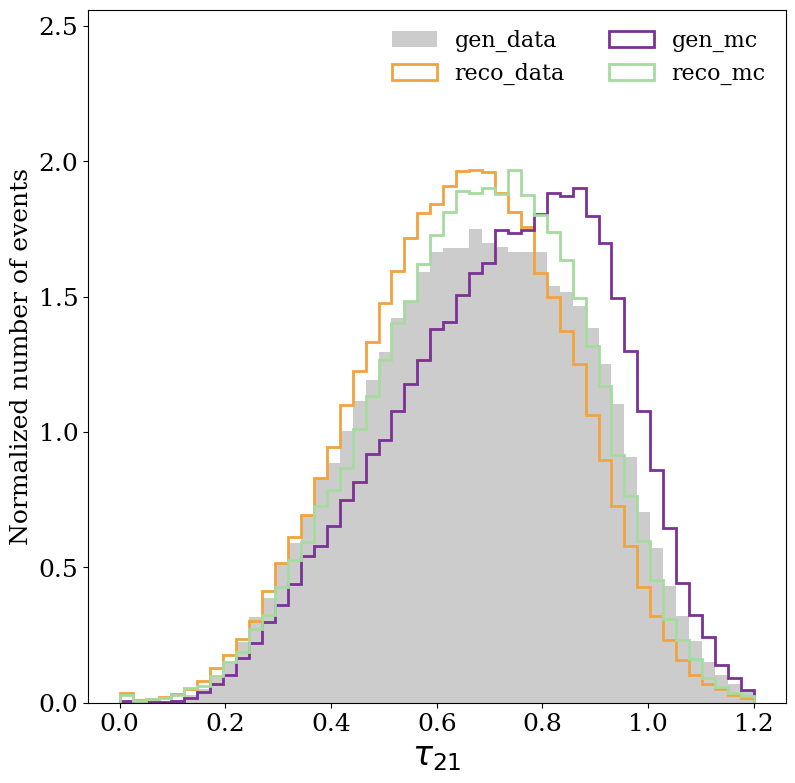

In [7]:
for iv, var in enumerate(var_names):
    data_dict = {
    'gen_data': gen_data[:,iv],
    'reco_data': reco_data[:,iv],
    'gen_mc': gen_mc[:,iv],
    'reco_mc': reco_mc[:,iv],
    }
    HistRoutine(data_dict,var, reference_name = 'gen_data',plot_ratio=False,binning=binning[iv])

## Let's now create the neural network models we are going to use to model the weight distributions

In [8]:
ndim = len(var_names)
model1 = MLP(ndim)
model2 = MLP(ndim)

In [9]:
print(model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,089
Trainable params: 17,089
Non-trainable params: 0
_________________________________________________________________
None


## Let's Unfold!

In [10]:
omnifold = MultiFold(
    "ZJets",
    model1,
    model2,
    data,
    mc,
    batch_size = 1024,
    niter = 1,  #Number of Iterations                                                                                                                                                                                                  
    epochs=10,      
    weights_folder = 'weights',
    verbose=True,
)

In [11]:
omnifold.Preprocessing()
omnifold.Unfold()

195 training steps at reco and 195 steps at gen
ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 199680, Test events used: 39935
################################################################################
Epoch 1/10
156/156 [==============================] - 4s 5ms/step - loss: 6.9360 - val_loss: 6.9166 - lr: 1.0000e-04
Epoch 2/10
156/156 [==============================] - 1s 5ms/step - loss: 6.9034 - val_loss: 6.9050 - lr: 1.0000e-04
Epoch 3/10
156/156 [==============================] - 1s 5ms/step - loss: 6.8995 - val_loss: 6.9011 - lr: 1.0000e-04
Epoch 4/10
156/156 [==============================] - 1s 8ms/step - loss: 6.8959 - val_loss: 6.8990 - lr: 1.0000e-04
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 6.8944 - val_loss: 6.9276 - lr: 1.0000e-04
Epoch 6/10
156/156 [==============================] - 1s 5ms/step - loss: 6.8932 - val_loss: 

## Now, let's evaluate the model!

In [12]:
validation_data = h5.File(os.path.join(data_path,'test_herwig.h5'))['gen_subs'][:]
unfolded_weights  = omnifold.reweight(validation_data,omnifold.model2,batch_size=1000)   

487/487 [==============================] - 0s 651us/step


## More plots!

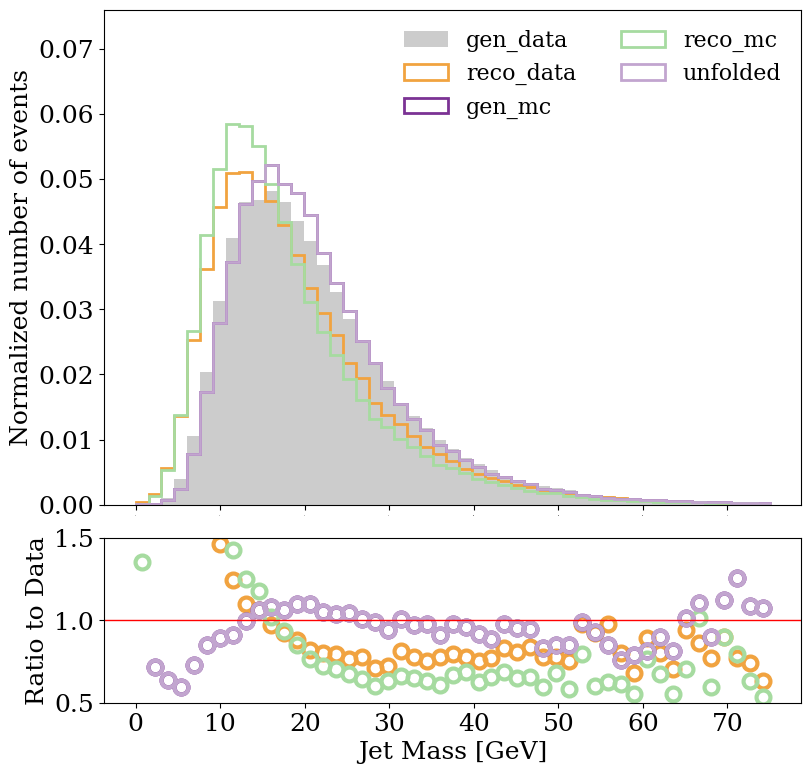

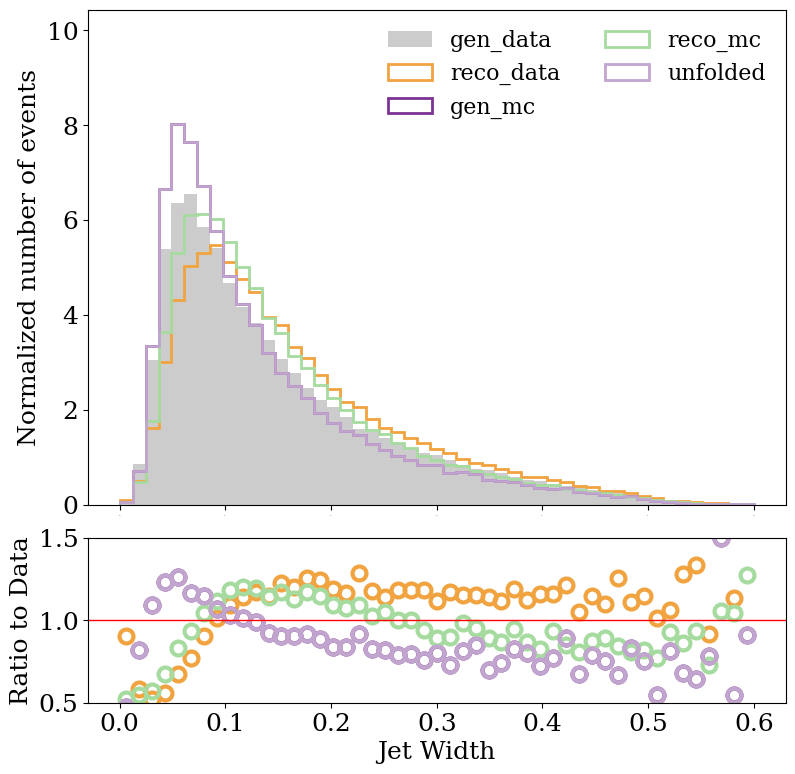

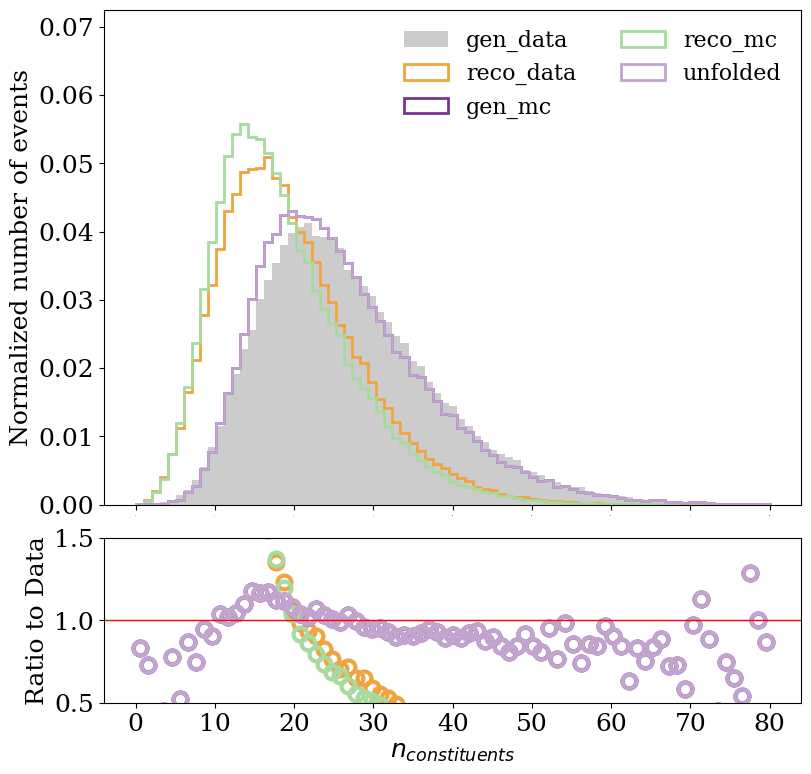

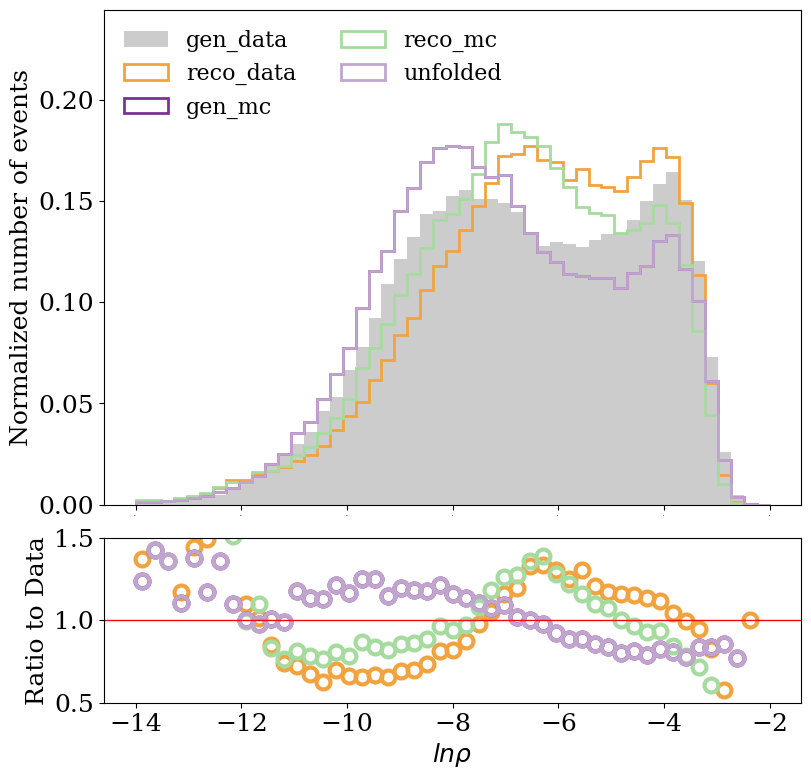

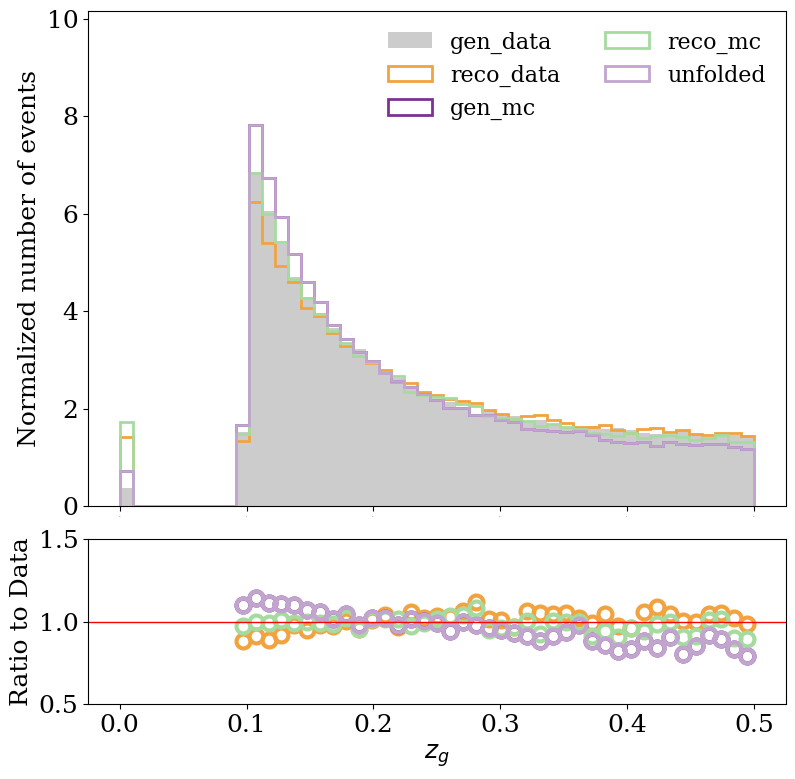

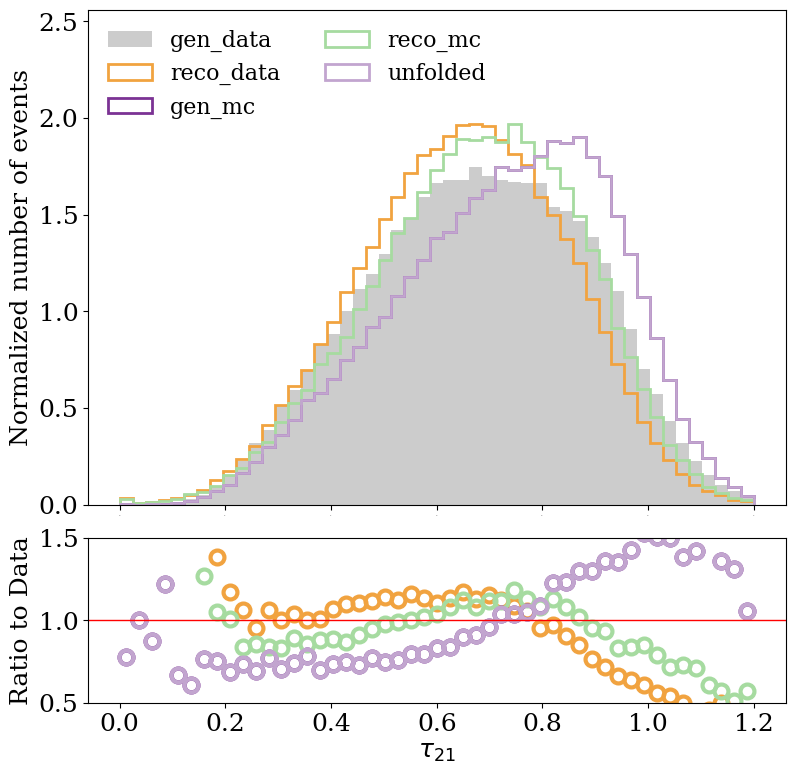

In [13]:
for iv, var in enumerate(var_names):
    data_dict = {
    'gen_data': gen_data[:,iv],
    'reco_data': reco_data[:,iv],
    'gen_mc': gen_mc[:,iv],
    'reco_mc': reco_mc[:,iv],
    'unfolded': gen_mc[:,iv],
    }
    weight_dict = {
    'gen_data': data.weight,
    'reco_data': data.weight,
    'gen_mc': mc.weight,
    'reco_mc': mc.weight,
    'unfolded': unfolded_weights,
    }
    HistRoutine(data_dict,var, reference_name = 'gen_data',binning=binning[iv])

# Exercises

## The unfolded distribution looks good, but not quite there yet. Try changing: 
* The number of OmniFold iterations
* The number of training epochs

## We use $ln\rho$ as one of the inputs, how does the plot for $\rho$ alone looks like?

## Let's create a new observable: Jet mass / Jet width. How does that distribution looks like for the unfolded events?